In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GODMAX.src import get_B12_profile
from colossus.cosmology import cosmology
from colossus.halo import profile_nfw, profile_outer, profile_composite, concentration
import seaborn as sns
import warnings

# Set up

In [2]:
cosmo = cosmology.setCosmology('illustris') #sets the cosmology for Colossus
snapshot_to_redshift = dict({99:0.0, 67:0.5, 50:1.0, 33:2.0})
z_to_snap = dict({0.0:99, 0.5:67, 1.0:50, 2.0:33})
k_B = 8.617*10**(-8) #Boltzmann constant in keV/K to convert K/cm^3 to keV/cm^3

In [3]:
halos_df = pd.read_hdf('illustris_profiles/TNG300-1_diffgas_snap99.hdf5', key = 'Halos').fillna(0)
halos = halos_df.to_numpy()
bins = np.geomspace(0.03, 2, 25)
halos_df

,HaloID_LastDesc,SubhaloID_LastDesc,SubhaloID,HaloID,M500c_TNG,R500c_TNG,M200c_TNG,R200c_TNG,MinRadius,Ndm,...,TGas_bin18,TGas_bin19,TGas_bin20,TGas_bin21,TGas_bin22,TGas_bin23,TGas_bin24,Mbh_Cen,Mbh_clean_Cen,EndState
0,0,0,0,0,15.062608,1630.108104,15.186332,2432.722030,0.000906,27086497,...,5.788231,5.432720,5.214119,4.959058,4.484128,4.525023,4.869372,11.005227,10.661781,Success
1,1,11748,11748,1,14.984198,1534.870734,15.116389,2305.659702,0.000962,21460914,...,5.833197,6.078924,5.682854,4.378369,3.532270,2.884896,2.367832,10.767000,10.503719,Success
2,2,17908,17908,2,14.847251,1381.758990,15.014232,2131.685179,0.001068,17584512,...,4.999264,5.124356,5.419457,3.681219,3.101917,2.511336,2.036802,10.786265,10.553609,Success
3,3,22736,22736,3,14.800140,1332.641007,14.954083,2035.555258,0.001108,15282178,...,4.200079,3.942853,3.800840,3.630940,3.227548,2.008086,1.440292,10.503048,10.225269,Success
4,4,27878,27878,4,14.777473,1309.683715,14.925219,1990.947335,0.001127,15207507,...,4.289899,3.543412,3.119022,2.707695,2.411590,2.165365,2.049211,10.601523,10.381518,Success
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2543,3583,1088527,1088527,3583,13.010947,337.541894,13.126042,500.423858,0.004373,242443,...,0.409328,0.361177,0.322076,0.281019,0.217630,0.193140,0.168149,8.981935,8.891629,Success
2544,3589,1088992,1088992,3589,13.018363,339.461136,13.150847,510.031309,0.004349,249969,...,0.414937,0.353796,0.310508,0.275107,0.235730,0.199506,0.159548,9.077581,9.030790,Success
2545,3596,1089654,1089654,3596,13.017939,339.360582,13.141873,506.549944,0.004350,252841,...,0.392672,0.353377,0.344571,0.288163,0.243920,0.199058,0.127081,9.083731,9.001923,Success
2546,3670,1096262,1096262,3670,13.031240,342.835572,13.122370,499.033718,0.004306,229759,...,0.338077,0.293237,0.259330,0.216941,0.180905,0.142391,0.115502,8.677184,8.594919,Success


# Functions

In [56]:
def b12_profile(M, z):
    return get_B12_profile.Battaglia_12_16(M, z)

#data_clean now accepts a single array or a list/tuple of arrays. mass filter needs to be log10.
def data_clean(inp, cutoff=10, log=False, mass_filter=None, outlier_cutoff=1.5, mass_rad_out=False):
    """Takes in either a single dataframe of sim data or a tuple of several.
    
    """
    if type(inp) is tuple or type(inp) is list:
        outp = []
        removal = []
        for df in inp:
            med = np.median(df, axis=0)
            curr = []
            remove_temp = []
            for i, row in enumerate(df):
                curr.append(row[cutoff:])
                mass = halos_df['M200c_TNG'].iloc[[i]].to_numpy()[0]
                if (row[cutoff] == 0.0) or (mass >= mass_filter[0] and mass <= mass_filter[1]) or (np.log10(np.max(row[19:]))-np.log10(np.max(med[19:])) > outlier_cutoff):
                    removal.append(i)
                if np.isnan(np.log10(np.max(row[19:]))-np.log10(np.max(med[19:]))):
                    print(f"row {row[19:]}, med {med[19:]}")
            outp.append(curr)
        
        removal = list(set(removal))
        if mass_rad_out:
            mass = halos_df['M500c_TNG'].to_numpy()
            radius = halos_df['R500c_TNG'].to_numpy()
            return(np.delete(mass, removal), np.delete(radius, removal), np.delete(outp[0], removal, axis=0), np.delete(outp[1], removal, axis=0))
        else:
            return([np.delete(x, removal, axis=0) for x in outp])
            

    else: 
        outp = []
        for i, row in enumerate(inp):
            if row[cutoff] != 0.0:
                outp.append(row[cutoff:])
            elif log:
                print(f'removed row {i}')
        return np.array(outp)


def profiles_from_redshift(snap, mass=1, plot=None, ax=None, norm=True, fmt='ko', plot_lim=None, double_plot=False, outlier_cutoff=1.5):
    """Takes in the snapshot number and outputs the Pressure and density profile, can also plot them with certain parameters.

    Args:
        snap: the desired snapshot number (33, 50, 67, 99)
        mass: which mass bin will be graphed (1, 2, 3), optional
        plot: None if no plotting, otherwise 'rho' or 'P' for density and pressure, respectively
        ax: the axis object to plot the profile on
        norm: if the profiles are normalized by the respective profiles (rho/NFW, P/B12)
        fmt: the formatting string for the plots
        plot_lim: cuts off the last N values of the graphs
        double_plot: determines if the plots are sim/model or sim and model separately
        outlier_cutoff: float, passed into data_clean for how far from the median a value has to be to remove the whole row from the dataset


    Returns:
        a tuple of the pressure and total density (P, rho). Each is now a 2D numpy array with each row being a profile of one cluster.
    """
    z = snapshot_to_redshift[snap]
    lbl = f'illustris_profiles/TNG300-1_diffgas_snap{snap}.hdf5'
    halos_df = pd.read_hdf(lbl, key = 'Halos').fillna(0)
    halos = halos_df.to_numpy()
    bins = np.geomspace(0.03, 2, 25)
    bins_plot = bins[10:]

    #Use the full distribution as a stand-in, just to get the mean and std to clean the data
    mass_arr = halos_df['M500c_TNG'].dropna().to_numpy()
    std = np.std(mass_arr)
    mid = np.mean(mass_arr)
    #calculate evenly spaced mass bins based on std of mass distribution
    new_mass = (mid-1.5*std, mid-0.5*std) if mass==1 else (mid-0.5*std, mid+0.5*std) if mass==2 else (mid+0.5*std, mid+1.5*std) if mass==3 else None

    P_dirty = halos[:,col_idx('PGas_bin0'):col_idx('PGas_bin24')+1]# * k_B

    rhoDM_dirty = halos[:,col_idx('rhoDM_bin0'):col_idx('rhoDM_bin24')+1]

    rhoG_dirty = halos[:,col_idx('rhoGas_bin0'):col_idx('rhoGas_bin24')+1]

    rhoStar_dirty = halos[:,col_idx('rhoStar_bin0'):col_idx('rhoStar_bin24')+1]

    rho_dirty = rhoDM_dirty + rhoG_dirty + rhoStar_dirty
    #clean P and rho for when we need them for graphing, and also grab M500 and R500 with the same number and order of elements
    if plot:
        mass_arr, rad_arr, P, rho = data_clean((P_dirty, rho_dirty), mass_filter=(new_mass[0], new_mass[1]), outlier_cutoff=outlier_cutoff, mass_rad_out=True)
    else:
        print(new_mass[0])
        P, rho = data_clean((P_dirty, rho_dirty), mass_filter=(new_mass[0], new_mass[1]), outlier_cutoff=outlier_cutoff)
    #fix some bugs with them being objects instead of numbers
    #print(len(mass_arr), len(rad_arr), len(P[0]))
    rho = rho.astype('float')
    P = P.astype('float')


    #set little h for physical units
    h = cosmo.Hz(z)/100
    model_mass = np.power(10, new_mass)/h
    label_mass = np.power(10, new_mass)
    if plot == 'rho':
        if norm or double_plot:
            plot_arr = []
            rawr = []
            for i, r in enumerate(rho):
                R500 = rad_arr[i]
                m = np.power(10, mass_arr[i])
                conc = concentration.modelBullock01(m/h, z)[0]
                #print(mass_arr[i], conc)
                p_nfw = profile_nfw.NFWProfile(M=m/h, c=conc, z=z, mdef='500c')
                fac = p_nfw.density(bins_plot*R500/h)/(h**2)
                plot_arr.append(r/fac)
                rawr.append(fac)
            plot_arr = np.array(plot_arr)
            fac = np.median(np.array(rawr), axis=0)
        else:
            fac = 1
            
        if double_plot:
            ax.plot(bins_plot[:plot_lim], np.median(rho, axis=0)[:plot_lim], fmt, label='Density Profile')
            ax.plot(bins_plot[:plot_lim], fac[:plot_lim], 'ro', label='NFW Profile')
            ax.set_ylabel(r"total matter density ($M_{\odot}/kpc^3$)")
            ax.legend()
        else:
            ax.plot(bins_plot[:plot_lim], np.median(rho/fac, axis=0)[:plot_lim], fmt, label='Density Profile/NFW Profile')
            ax.set_ylabel(r"total matter density/NFW profile")
 
        ax.set_xlabel('Radial Bins ($R/R_{500c}$)')
        #ax.set_ylabel(r"Density (M_sun/kpc^3")
        ax.set_yscale('log')
        title = f"Density, mass=({label_mass[0]:.2e}, {label_mass[1]:.2e}), z={z}"
        ax.set_title(title)
        ax.grid()

    elif plot == 'P':
        # if norm == 'b12':

        if norm or double_plot:
            plot_arr = []
            rawr = []
            for i, p in enumerate(P):
                R500 = rad_arr[i]
                m = np.power(10, mass_arr[i])
                b12 = b12_profile(m, z)
                fac = b12.get_P_fit(bins_plot*R500/1000/h)
                plot_arr.append(p/fac)
                rawr.append(fac)
            plot_arr = np.array(plot_arr)
            fac = np.median(np.array(rawr), axis=0)
        else:
            fac = 1
            
        if double_plot:
            ax.plot(bins_plot[:plot_lim], np.median(P, axis=0)[:plot_lim], fmt, label='Pressure Profile')
            ax.plot(bins_plot[:plot_lim], fac[:plot_lim], 'go', label='B12 Profile')
            ax.set_ylabel(r"Pressure ($keV/cm^3$)")
            ax.legend()
        else:
            ax.plot(bins_plot[:plot_lim], np.median(P/fac, axis=0)[:plot_lim], fmt, label='Pressure Profile/B12 Profile')
            ax.set_ylabel(r"Pressure/B12 profile")

        ax.set_xlabel('Radial Bins ($R/R_{500c}$)')
        #ax.set_ylabel(r"Density (M_sun/kpc^3")
        ax.set_yscale('log')
        title = f"Pressure, mass=({label_mass[0]:.2e}, {label_mass[1]:.2e}), z={z}"
        ax.set_title(title)
        ax.grid()
        
    return (P, rho)

def col_idx(col_name):
    return halos_df.columns.get_loc(col_name)

#Calculates cross-correlation matrix or cross-covariance matrix
def cross_correlate(arr1, arr2, cov=False):
    avg1 = np.mean(arr1, axis=0)
    avg2 = np.mean(arr2, axis=0)
    std1 = np.std(arr1, axis=0) if not cov else np.ones(arr1.shape[1])
    std2 = np.std(arr2, axis=0) if not cov else np.ones(arr2.shape[1])
    row_len = arr1.shape[1]
    return [[(np.mean(arr1[:, i] * arr2[:, j]) - avg1[i] * avg2[j]) / (std1[i] * std2[j]) for i in range(row_len)] for j in range(row_len)]

# Filter out high and lows mass clusters according to the bounds
def filter_rows_by_mass(masses, lower_bound, upper_bound):
    indices = np.where((masses >= lower_bound) & (masses <= upper_bound))[0]
    return indices

# Function to filter 2D numpy array using the indices
def filter_2d_array(arr, indices):
    return arr[indices, :]


def filter_rows_by_stellar(S, lower_bound=10000):
    indices = np.where(S[:, 10:] >= lower_bound)[0]
    return indices


def plot_corr(ax, arrX, arrY, snap=99, mass_bin=1, cov=False):
    """Plots the cross-correlation between arrX and arrY

    Args:
        ax: the axes upon which to graph the correlation
        arrX (str): the name of the X axis ('P' or 'rho') OR the first array
        arrY (str): the name of the Y axis ('P' or 'rho') OR the second array
        snap: the Illustris snapshot to use, which corresponds to the redshift (99:0, 67:0.5, 50:1, 33:2)
        mass_bin: which mass bin to plot (1,2,3), anything else will make no cuts based on mass
        cov: passed into cross_correlate, determines is correlation or covariance is plotted

    Returns:
        heat: the correlation matrix between arrX and arrY

    """
    halos_df = pd.read_hdf(f'illustris_profiles/TNG300-1_diffgas_snap{snap}.hdf5', key='Halos').fillna(0)

    # Convert to numpy array
    halos = halos_df.to_numpy()

    def col_idx(column_name):
        return halos_df.columns.get_loc(column_name)

    mass = halos_df['M500c_TNG'].dropna().to_numpy()
    std = np.std(mass)
    mid = np.mean(mass)
    mass_ranges = [
        (mid-1.5*std, mid-0.5*std, f'MASS ({10**(mid-1.5*std):0.2e}, {10**(mid-0.5*std):0.2e})'),
        (mid-0.5*std, mid+0.5*std, f'mass = ({10**(mid-0.5*std):0.2e}, {10**(mid+0.5*std):0.2e})'),
        (mid+0.5*std, mid+1.5*std, f'mass = ({10**(mid+0.5*std):0.2e}, {10**(mid+1.5*std):0.2e})')
    ]
    # halos_df = pd.read_hdf(f'illustris_profiles/TNG300-1_diffgas_snap{snap}.hdf5', key = 'Halos').fillna(0)

    # mass = halos_df['M500c_TNG'].dropna().to_numpy()
    # std = np.std(mass)
    # mid = np.mean(mass)
    # new_mass = (mid-1.5*std, mid-0.5*std) if mass_bin==1 else (mid-0.5*std, mid+0.5*std) if mass_bin==2 else (mid+0.5*std, mid+1.5*std) if mass_bin==3 else None
    
    #label_mass = np.power(10, new_mass)

    S = halos[:, col_idx('rhoStar_bin9'):col_idx('rhoStar_bin24')+1].astype(float)

    # Get indices of rows with stellar mass in the specified range
    stellar_indices = filter_rows_by_stellar(S)

    # Remove these rows from the DataFrame
    halos_df_filtered = halos_df.drop(index=halos_df.index[stellar_indices])

    # Convert the filtered DataFrame back to a numpy array
    halos_filtered = halos_df_filtered.to_numpy()

    # Update the arrays after filtering
    mass = halos_filtered[:, col_idx('M200c_TNG')]
    P = halos_filtered[:, col_idx('PGas_bin9'):col_idx('PGas_bin24')+1].astype(float) * k_B

    S = halos_filtered[:, col_idx('rhoStar_bin9'):col_idx('rhoStar_bin24')+1].astype(float)

    D = halos_filtered[:, col_idx('rhoDM_bin9'):col_idx('rhoDM_bin24')+1].astype(float)

    T = halos_filtered[:, col_idx('TGas_bin9'):col_idx('TGas_bin24')+1].astype(float)

    V = halos_filtered[:, col_idx('rhoGas_bin9'):col_idx('rhoGas_bin24')+1].astype(float)

    rho = D + S + V
    
    if type(arrX) == str:
        arr1 = rho if arrX=='rho' else P
        arr2 = rho if arrY=='rho' else P
    else:
        arr1 = arrX
        arr2 = arrY

    indices = filter_rows_by_mass(mass, mass_ranges[mass_bin-1][0], mass_ranges[mass_bin-1][1])

    heat = cross_correlate(filter_2d_array(arr1, indices), filter_2d_array(arr2, indices))
    #heat = cross_correlate(arr1, arr2, cov)
    heatmap = sns.heatmap(heat, annot=False, fmt='.2f', cmap='coolwarm', cbar=True, vmin=-1, vmax=1, ax=ax)
    title = f"{mass_ranges[mass_bin-1][2]}, z={snapshot_to_redshift[snap]}"
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Pressure bins', fontsize=12)
    ax.set_ylabel('Density bins', fontsize=12)

    ax.tick_params(axis='x', labelrotation=0)
    ax.tick_params(axis='y', labelrotation=0)
    return heat

C:\Users\rocco\AppData\Local\Temp\ipykernel_37292\3316583350.py:21: RuntimeWarning: divide by zero encountered in log10
  if np.isnan(np.log10(np.max(row[19:]))-np.log10(np.max(med[19:]))):
C:\Users\rocco\AppData\Local\Temp\ipykernel_37292\3316583350.py:21: RuntimeWarning: divide by zero encountered in log10
  if np.isnan(np.log10(np.max(row[19:]))-np.log10(np.max(med[19:]))):


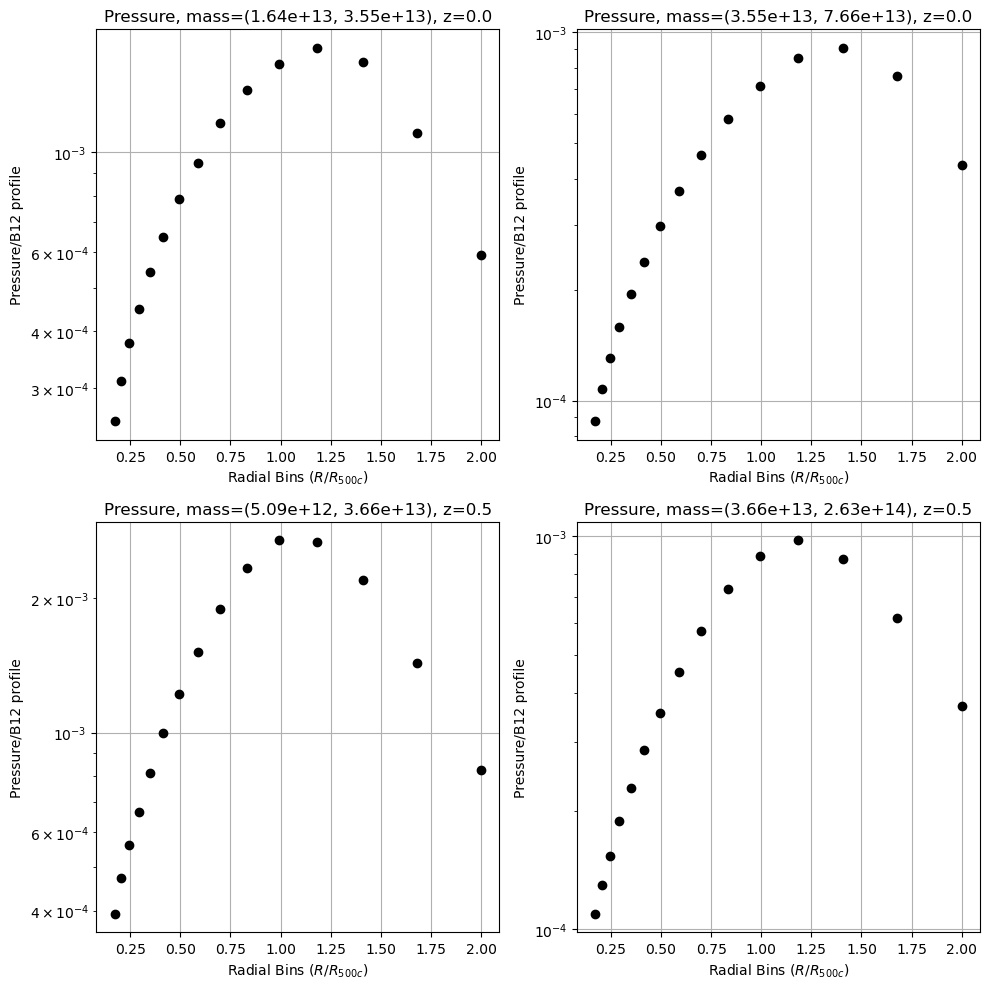

In [5]:
to_norm = True
dp = False
lim = None
#warnings.filterwarnings("ignore")

fig, ax = plt.subplots(2,2, figsize=(10,10))
to_plot = 'P'
_ = profiles_from_redshift(snap=99, norm=to_norm, mass=2, plot=to_plot, ax=ax[0,0], plot_lim=lim, fmt='ko', double_plot=dp)
_ = profiles_from_redshift(snap=67, norm=to_norm, mass=2, plot=to_plot, ax=ax[1,0], plot_lim=lim, fmt='ko', double_plot=dp)
_ = profiles_from_redshift(snap=99, norm=to_norm, mass=3, plot=to_plot, ax=ax[0,1], plot_lim=lim, fmt='ko', double_plot=dp)
_ = profiles_from_redshift(snap=67, norm=to_norm, mass=3, plot=to_plot, ax=ax[1,1], plot_lim=lim, fmt='ko', double_plot=dp)

fig.tight_layout()

# Correlation

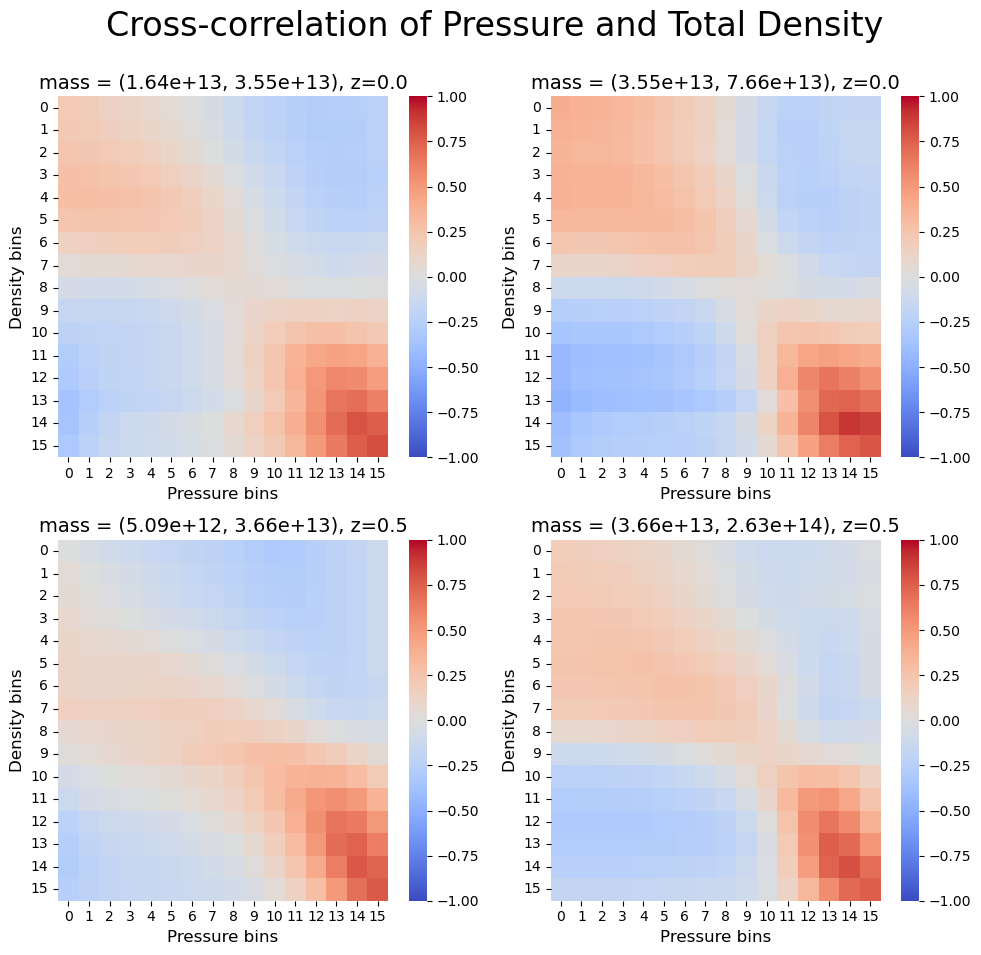

In [57]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
warnings.filterwarnings('ignore')

plot_corr(ax[0,0], 'P', 'rho', 99, 2)
plot_corr(ax[0,1], 'P', 'rho', 99, 3)
plot_corr(ax[1,0], 'P', 'rho', 67, 2)
plot_corr(ax[1,1], 'P', 'rho', 67, 3)


fig.suptitle('Cross-correlation of Pressure and Total Density', fontsize=24, y=0.95)
fig.tight_layout(rect=[0.0, 0.0, 1, 0.95])
plt.show()

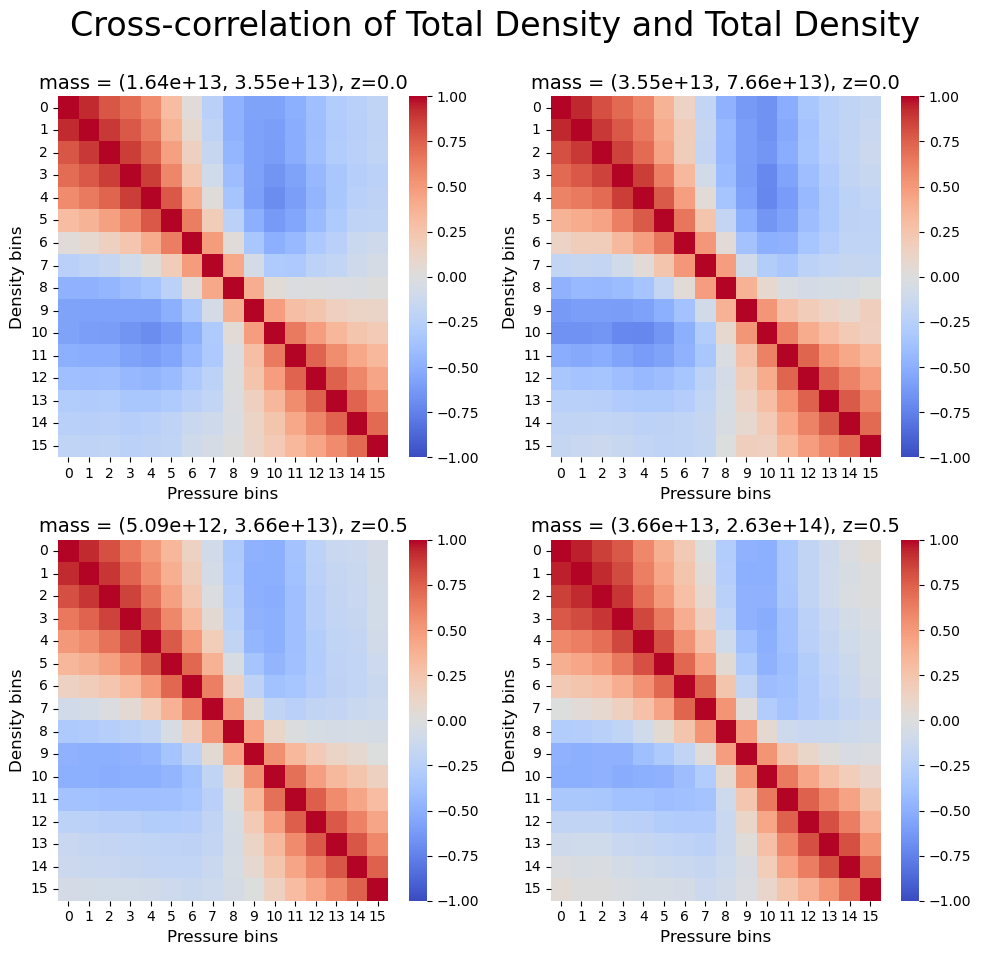

In [58]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
warnings.filterwarnings('ignore')

plot_corr(ax[0,0], 'rho', 'rho', 99, 2)
plot_corr(ax[0,1], 'rho', 'rho', 99, 3)
plot_corr(ax[1,0], 'rho', 'rho', 67, 2)
plot_corr(ax[1,1], 'rho', 'rho', 67, 3)


fig.suptitle('Cross-correlation of Total Density and Total Density', fontsize=24, y=0.95)
fig.tight_layout(rect=[0.0, 0.0, 1, 0.95])
plt.show()

# Plotting Profiles

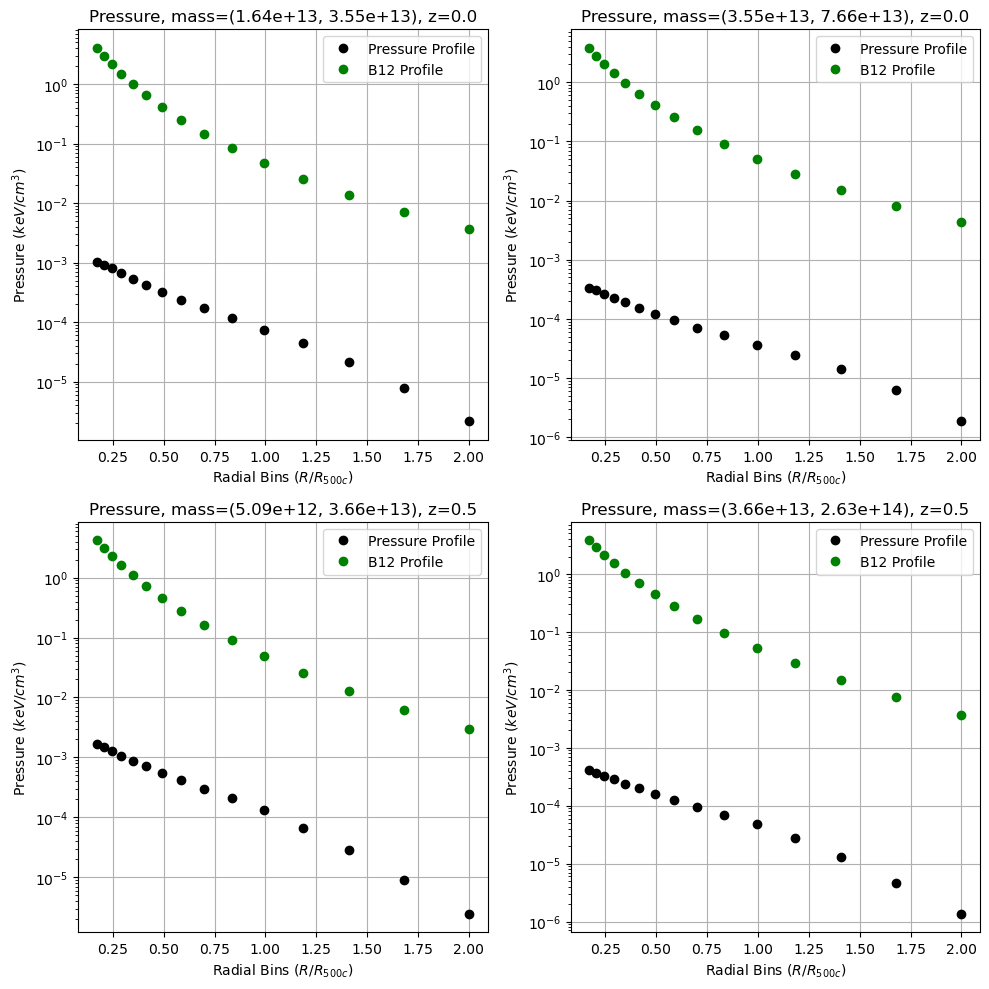

In [59]:
to_plot = 'rho' #change this between 'rho' or 'P'
to_norm = True #turning this off only graphs the sim profile
warnings.filterwarnings("ignore")
fig, ax = plt.subplots(2,2, figsize=(10,10))
lim = None

#second and third mass bins
mass2 = 2 
mass3 = 3

dp = True #if you want to plot the ratio or the two profiles separately

_ = profiles_from_redshift(snap=99, norm=to_norm, mass=mass2, plot=to_plot, ax=ax[0,0], plot_lim=lim, fmt='ko', double_plot=dp)
_ = profiles_from_redshift(snap=67, norm=to_norm, mass=mass2, plot=to_plot, ax=ax[1,0], plot_lim=lim, fmt='ko', double_plot=dp)
_ = profiles_from_redshift(snap=99, norm=to_norm, mass=mass3, plot=to_plot, ax=ax[0,1], plot_lim=lim, fmt='ko', double_plot=dp)
_ = profiles_from_redshift(snap=67, norm=to_norm, mass=mass3, plot=to_plot, ax=ax[1,1], plot_lim=lim, fmt='ko', double_plot=dp)
fig.tight_layout()